# Test the fftfit implementation in Stingray

FFTfit was developed by Joe Taylor and is among the most used algorithms in pulsar astronomy. 
It is used to calculate the Times-of-arrival (TOA) of the pulses. TOAs can then be used to measure discrepancies or small errors in the timing solution, calculate precisely the orbit, calculate post-Keplerian parameters, win a Nobel prize, etc (that's what Joe did).
Different implementations exist of this algorithm, which basically minimizes the chi square of the _Fourier Transform_ of the measured pulse profile and a template in order to calculate the phase of the profile itself.

Here we test the python implementation of the FFTfit algorithm in Stingray. 

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import seaborn as sb
mpl.rcParams['figure.figsize'] = (15, 10)

Let us define a Crab-like pulse profile here

In [2]:
from astropy.modeling import models, fitting, custom_model
# Define model
@custom_model
def sum_of_gaussians(x, baseline=0,
                        amplitude1=1., mean1=-1., sigma1=1.,
                        amplitude2=1., mean2=1., sigma2=1.):

    funval0 = (amplitude1 * np.exp(-0.5 * ((x - mean1) / sigma1)**2) +
               amplitude2 * np.exp(-0.5 * ((x - mean2) / sigma2)**2))
    funval1 = (amplitude1 * np.exp(-0.5 * ((x - mean1 - 1) / sigma1)**2) +
               amplitude2 * np.exp(-0.5 * ((x - mean2 - 1) / sigma2)**2))
    funval2 = (amplitude1 * np.exp(-0.5 * ((x - mean1 + 1) / sigma1)**2) +
               amplitude2 * np.exp(-0.5 * ((x - mean2 + 1) / sigma2)**2))

    return baseline + funval0 + funval1 + funval2

def double_gauss(phase, profile):
    height = np.max(profile) - np.min(profile)
    peak = phase[np.argmax(profile)]
    mod = sum_of_gaussians(baseline=np.mean(profile), 
                           mean1=peak, mean2=peak + 0.4,
                           amplitude1=height, amplitude2=height/2,
                           sigma1=0.02, sigma2=0.02)
    def x_1_p_0d4(mod): return mod.mean1 + 0.4
    mod.mean2.tied = x_1_p_0d4
    fitter = fitting.LevMarLSQFitter()

    newmod = fitter(mod, phase, profile)
    fine_phase = np.arange(0, 1, 0.0001)
    fine_template = newmod(fine_phase)
    additional_phase = fine_phase[np.argmax(fine_template)]
    plt.figure()
    plt.plot(phase, profile)
    allph = fine_phase
    plt.plot(allph, mod(allph), ls='--')
    plt.plot(allph, newmod(allph))
    return newmod, additional_phase

def skewed_moffat(x, mean, amplitude, alpham, alphap, beta):
    lt0 = (x-mean) < 0
#     gt0 = np.logical_not(lt0)
    ratio = ((x-mean)/alphap)**2
    ratio[lt0] = ((x[lt0]-mean)/alpham)**2
    return amplitude * ( 1 + ratio)**(-beta)

# Define model
@custom_model
def sum_of_moffats(x, baseline=0,
                   amplitude1=1., mean1=0., alpham1=0.05, alphap1=0.05, beta1=1,
                   amplitude2=1., mean2=0.4, alpham2=0.05, alphap2=0.05, beta2=1):

    funval0 = (skewed_moffat(x, mean1, amplitude1, alpham1, alphap1, beta1) +
               skewed_moffat(x, mean2, amplitude2, alpham2, alphap2, beta2))
    funval1 = (skewed_moffat(x - 1, mean1, amplitude1, alpham1, alphap1, beta1) +
               skewed_moffat(x - 1, mean2, amplitude2, alpham2, alphap2, beta2))
    funval2 = (skewed_moffat(x + 1, mean1, amplitude1, alpham1, alphap1, beta1) +
               skewed_moffat(x + 1, mean2, amplitude2, alpham2, alphap2, beta2))

    return baseline + funval0 + funval1 + funval2

def double_moffat(phase, profile):
    height = np.max(profile) - np.min(profile)
    peak = phase[np.argmax(profile)]
    mod = sum_of_moffats(baseline=np.mean(profile), 
                         mean1=peak, mean2=peak + 0.4,
                         amplitude1=height, amplitude2=height/2,
                         alpham1=0.02, alpham2=0.02, alphap1=0.02, alphap2=0.02)
    def x_1_p_0d4(mod): return mod.mean1 + 0.4
    mod.mean2.tied = x_1_p_0d4
    fitter = fitting.LevMarLSQFitter()

    newmod = fitter(mod, phase, profile)
    fine_phase = np.arange(0, 1, 0.0001)
    fine_template = newmod(fine_phase)
    additional_phase = fine_phase[np.argmax(fine_template)]
    plt.figure()
    plt.plot(phase, profile)
    allph = fine_phase
    plt.plot(allph, mod(allph), ls='--')
    plt.plot(allph, newmod(allph))
    return newmod, additional_phase


<IPython.core.display.Javascript object>


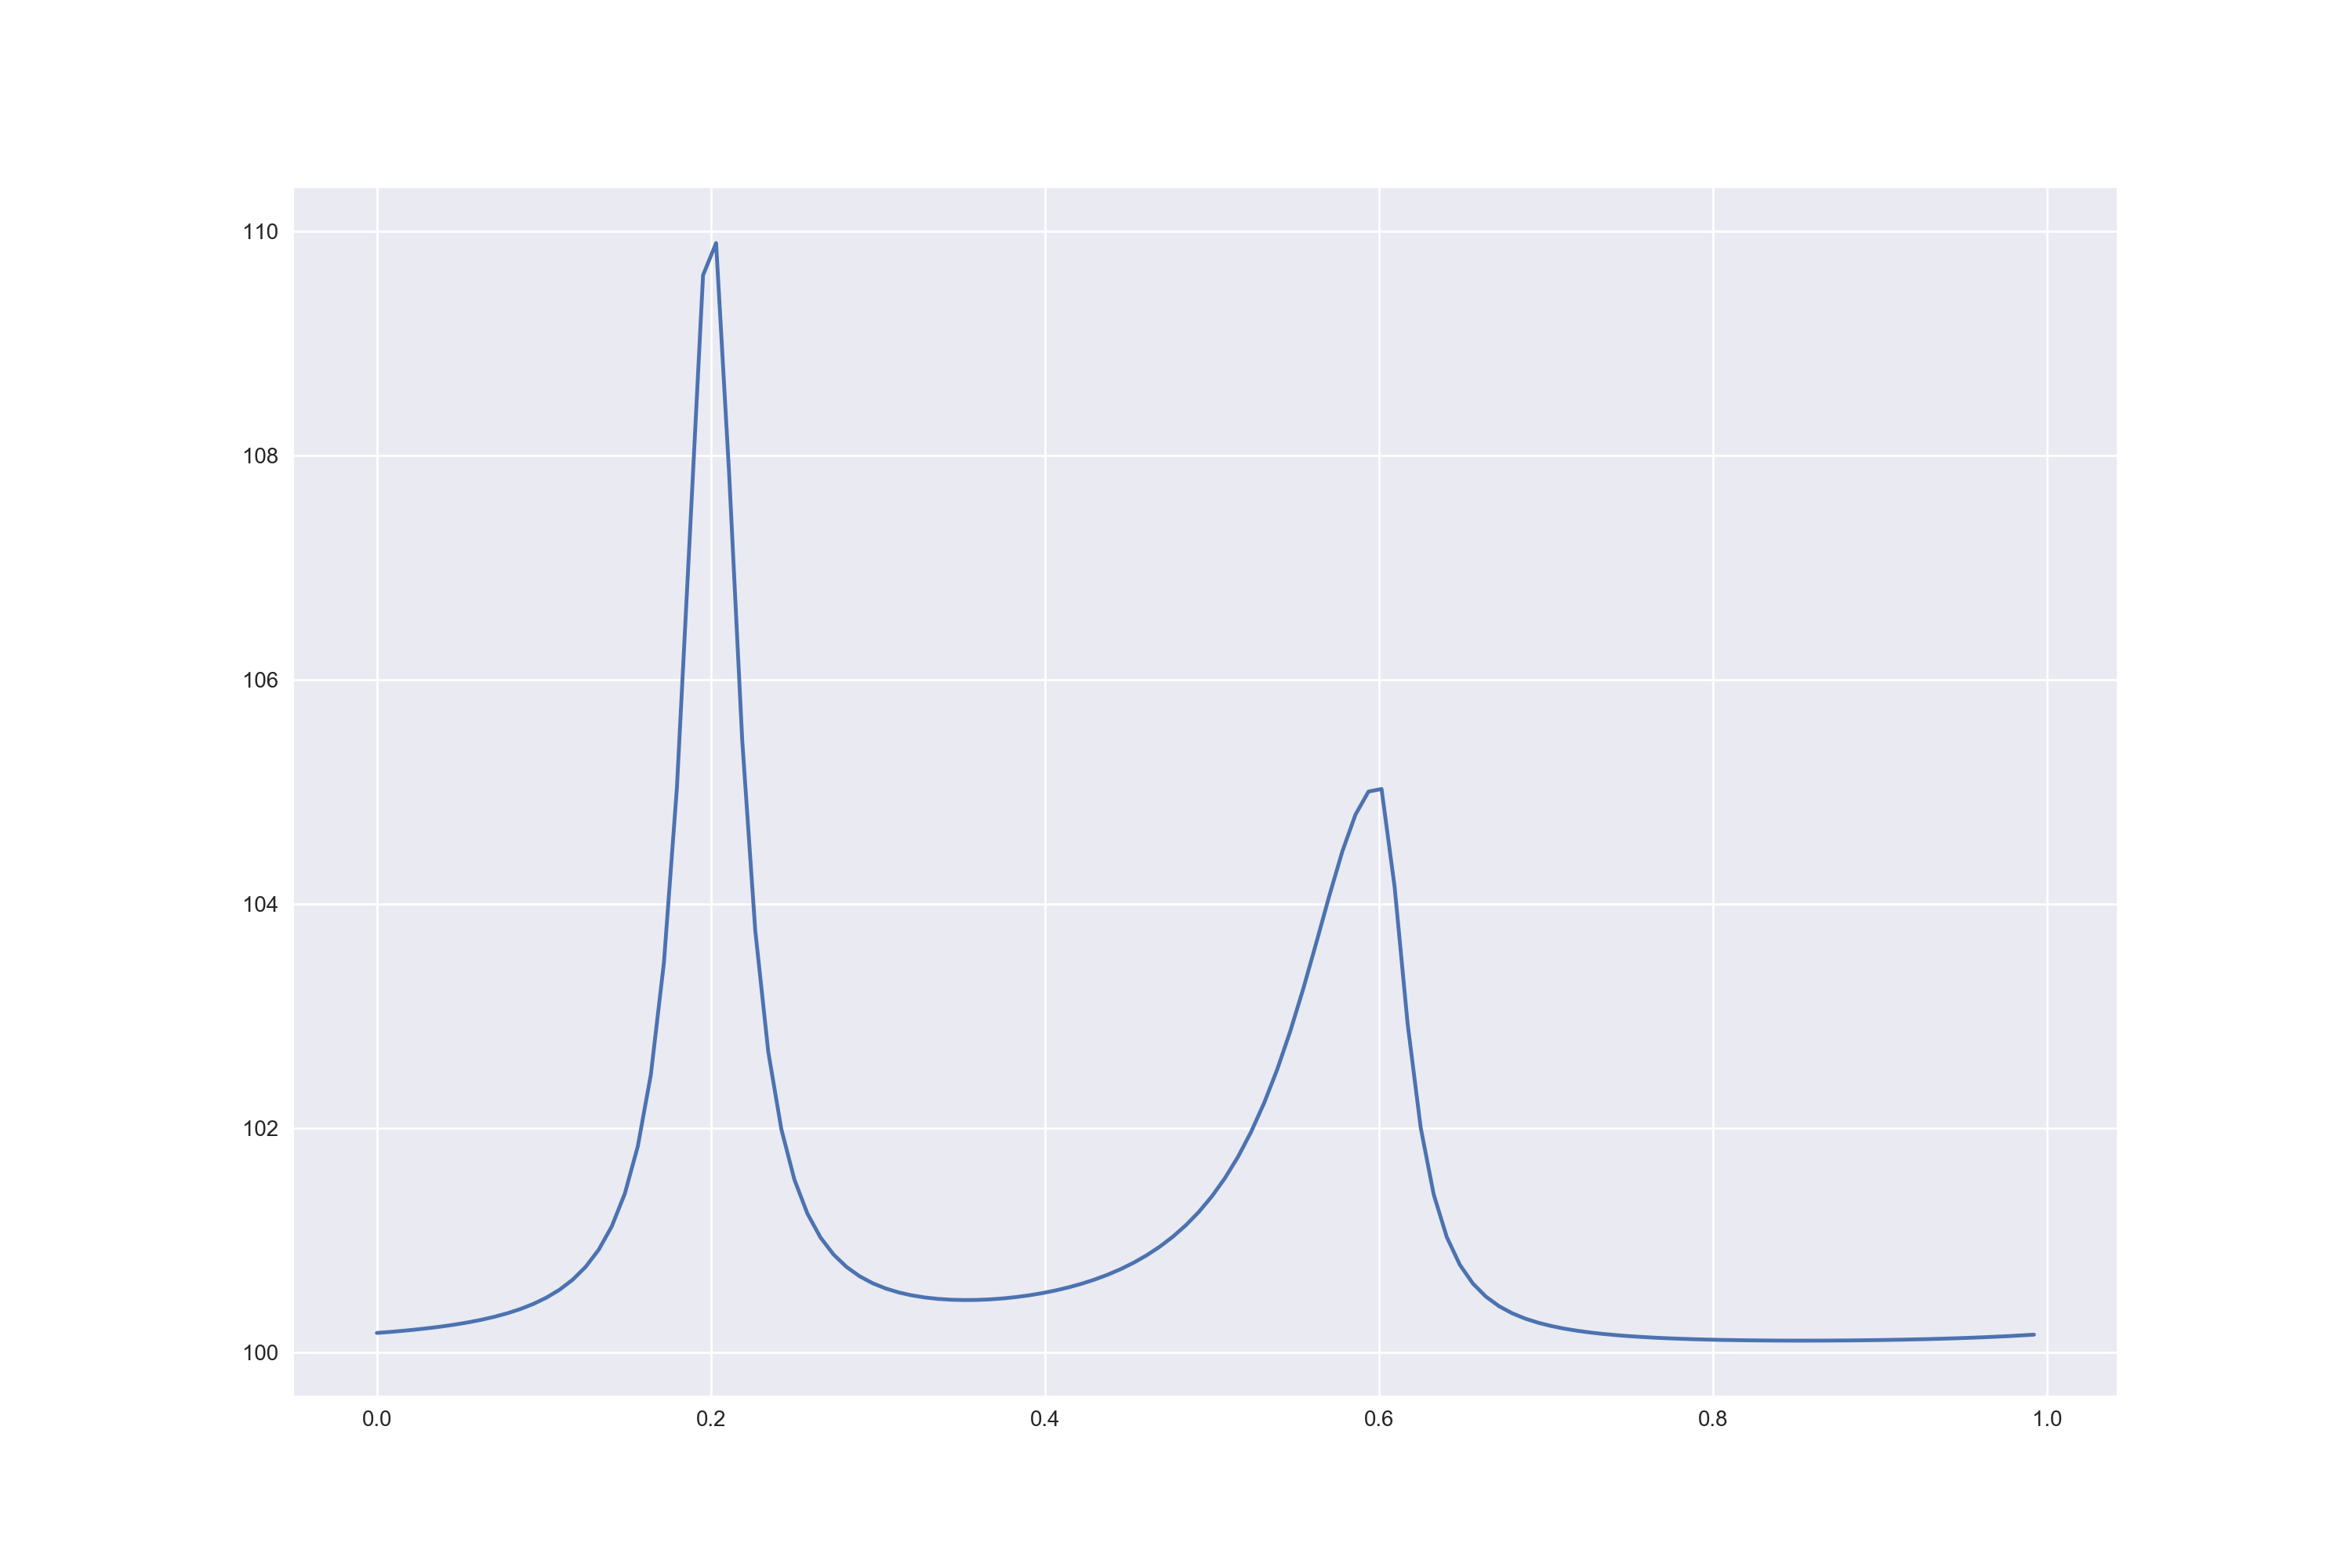

In [3]:
# Create light curve

mod = sum_of_moffats(baseline=100, 
                     mean1=0.2, mean2=0.6,
                     amplitude1=10, amplitude2=5,
                     alpham1=0.02, alpham2=0.06, alphap1=0.02, alphap2=0.02)

phases = np.arange(0, 1, 1/128)
template = mod(phases)
plt.figure()
plt.plot(phases, template)


The function to minimize is the following:

In [4]:
def fftfit_fun(profile, template, amplitude, phase):
    '''Function to be minimized for the FFTFIT method.
    
    From Taylor (1992).
    
    Parameters
    ----------
    profile : array
        The pulse profile
    template : array
        A pulse shape template, of the same length as profile.
    amplitude, phase : float
        The amplitude and phase of the template w.r.t the real profile.
    Returns
    -------
    fftfit_chisq : float
        The chi square-like statistics of FFTFIT
    '''

    prof_ft = np.fft.fft(profile)
    temp_ft = np.fft.fft(template)
    freq = np.fft.fftfreq(len(profile))
    good = freq > 0
    idx = np.arange(0, len(prof_ft), dtype=int)
    sigma = np.std(prof_ft[good])
    return np.sum(np.absolute(prof_ft -
                  temp_ft*amplitude*np.exp(-2*np.pi*1.0j*idx*phase))**2 / sigma)

Now we can define the algorithm that minimizes the function above. For the minimization, we define two algorithms:

+ `quick=True` to use `scipy.minimize`, making some rough assumptions about the initial parameters of the fit

+ `quick=False` to use `scipy.basinhopping`, a brute-force method that explores the parameter space "jumping" from one minimum to the other. This is much slower, but more precise.

To calculate the errors on the fit, we can use a bootstrap method. `fftfit_error` can be improved, this is probably not as good as it should be right now. A conservative assumption on the error (half a bin) is currently recommended.

In [5]:
from scipy.optimize import minimize, basinhopping, curve_fit
from stingray.pulse.pulsar import _fft_fun_wrap
from stingray.utils import mad
from scipy.signal import savgol_filter
from scipy.interpolate import interp1d
import time


def _fft_fun_wrap(pars, data):
    '''Wrap parameters and input data of FFTfit.'''
    amplitude, phase = pars
    profile, template = data
    return fftfit_fun(profile, template, amplitude, phase)

        
def fftfit(prof, template=None, quick=False, sigma=None, use_bootstrap=False,
           **fftfit_kwargs):
    """Align a template to a pulse profile.

    Parameters
    ----------
    phase : array
        The phases corresponding to each bin of the profile
    prof : array
        The pulse profile
    template : array, default None
        The template of the pulse used to perform the TOA calculation. If None,
        a simple sinusoid is used

    Returns
    -------
    mean_amp, std_amp : floats
        Mean and standard deviation of the amplitude
    mean_phase, std_phase : floats
        Mean and standard deviation of the phase

    Other Parameters
    ----------------
    fftfit_kwargs : arguments
        Additional arguments to be passed to error calculation
    """
    prof = prof - np.mean(prof)
    if sigma is None:
        sigma = np.sqrt(prof)

    nbin = len(prof)

    ph = np.arange(0, 1, 1/nbin)
    if template is None:
        template = np.cos(2 * np.pi * ph)
    template = template - np.mean(template)

    dph = np.float((np.argmax(prof) - np.argmax(template) - 0.2) / nbin)
    while dph > 0.5:
        dph -= 1.
    while dph < -0.5:
        dph += 1.

    if quick:
        min_chisq = 1e32

        binsize = 1/nbin
        for d in np.linspace(-0.5, 0.5, nbin/2):
            p0 = [1, dph + d]

            res_trial = minimize(_fft_fun_wrap, p0, args=([prof, template],),
                                 method='L-BFGS-B',
                                 bounds=[[0, None], [dph + d - binsize, dph + d + binsize]],
                                 options={'maxiter': 10000})
            chisq = _fft_fun_wrap(res_trial.x, [prof, template]) 

            if chisq < min_chisq:
                min_chisq = chisq
                res = res_trial
    else:
        p0 = [np.max(prof), dph]

        res = basinhopping(_fft_fun_wrap, p0,
                           minimizer_kwargs={'args': ([prof, template],),
                                             'bounds': [[0, None], [-1, 1]]},
                           niter=1000, niter_success=200).lowest_optimization_result

    chisq = _fft_fun_wrap(res.x, [prof, template]) 

    while res.x[1] > 0.5:
        res.x[1] -= 1.
    while res.x[1] < -0.5:
        res.x[1] += 1.

    if not use_bootstrap:
        return res.x[0], 0, res.x[1], 0.5 / nbin
    else:
        mean_amp, std_amp, mean_ph, std_ph = \
            fftfit_error(template, sigma=mad(np.diff(prof)), **fftfit_kwargs)
        return res.x[0] + mean_amp, std_amp, res.x[1] + mean_ph, std_ph

    
def fftfit_error(template, sigma=None, **fftfit_kwargs):
    """Calculate the error on the fit parameters from FFTFIT.
    Parameters
    ----------
    phase : array
        The phases corresponding to each bin of the profile
    prof : array
        The pulse profile
    template : array
        The template of the pulse used to perform the TOA calculation
    p0 : list
        The initial parameters for the fit
    Returns
    -------
    mean_amp, std_amp : floats
        Mean and standard deviation of the amplitude
    mean_phase, std_phase : floats
        Mean and standard deviation of the phase
    Other parameters
    ----------------
    nstep : int, optional, default 100
        Number of steps for the bootstrap method
    """
    nstep = _default_value_if_no_key(fftfit_kwargs, "nstep", 100)

    if sigma is None:
        sigma = np.sqrt(np.mean(template))
 
    print(sigma)
    nbin = len(template)

    ph_fit = np.zeros(nstep)
    amp_fit = np.zeros(nstep)
    # use bootstrap method to calculate errors
    shift = 0
    phase = np.arange(0, 1, 1 / nbin)
    maxphase = np.argmax(template) / nbin

    for i in range(nstep):
        shift = i
        newprof = np.random.normal(0, sigma, len(template)) + template
        dph = np.random.normal(0, 0.5 / nbin)
        p0 = [1, dph]
        res = minimize(_fft_fun_wrap, p0, args=([newprof, template],),
                       method='L-BFGS-B',
                       bounds=[[0, None], [-1, 1]],
                                 options={'maxiter': 10000})
        
        amp_fit[i] = res.x[0]
        while res.x[1] > 0.5:
            res.x[1] -= 1
        while res.x[1] < -0.5:
            res.x[1] += 1
        ph_fit[i] = res.x[1]
        
    plt.figure()
    m = np.median(ph_fit)
    s = mad(ph_fit)
    plt.hist(ph_fit, bins=np.linspace(m - 3 * s, m + 3 * s, 11))
    
    std_save = 1e32
    # avoid problems if phase around 0 or 1: shift, calculate std,
    # if less save new std
    for shift in np.arange(0, 0.8, 0.2):
        phs = ph_fit + shift
        phs -= np.floor(phs)
        std = np.std(phs)
        std = mad(phs)
        if std < std_save:
            std_save = std
            mean_save = np.median(phs) - shift

#     print(np.mean(amp_fit), np.std(amp_fit), mean_save, std_save)
    return np.mean(amp_fit), np.std(amp_fit), mean_save, std_save


def _default_value_if_no_key(dictionary, key, default):
    try:
        return dictionary[key]
    except:
        return default




and finally, a function to get these phases and transform them into an arrival time.

In [6]:
def plot_TOA_fit(profile, template, toa, mod=None, toaerr=None,
                 additional_phase=0., show=True, period=1):
    window = 5
    phases = np.arange(0, 1, 1 / len(profile))
    if mod is None:
        mod = interp1d(phases, template, fill_value='extrapolate')

    fig = plt.figure()
    plt.plot(phases - np.floor(phases), profile, drawstyle='steps-mid')
    fine_phases = np.linspace(0, 1, 1000)
    fine_phases_shifted = fine_phases - toa / period + additional_phase
    plt.plot(fine_phases, mod(fine_phases_shifted - np.floor(fine_phases_shifted)))
    if toaerr is not None:
        plt.axvline((toa - toaerr) / period)
        plt.axvline((toa + toaerr) / period)
    plt.axvline(toa / period - 0.5/len(profile), ls='--')
    plt.axvline(toa / period + 0.5/len(profile), ls='--')
    timestamp = int(time.time())
    plt.savefig('{}.png'.format(timestamp))
    if not show:
        plt.close(fig)

    
def get_TOA(prof, period, tstart, template=None, additional_phase=0,
            quick=False, debug=False, use_bootstrap=False,
            **fftfit_kwargs):
    """Calculate the Time-Of-Arrival of a pulse.
    Parameters
    ----------
    prof : array
        The pulse profile
    template : array, default None
        The template of the pulse used to perform the TOA calculation, if any.
        Otherwise use the default of fftfit
    tstart : float
        The time at the start of the pulse profile
    Returns
    -------
    toa, toastd : floats
        Mean and standard deviation of the TOA
    Other parameters
    ----------------
    nstep : int, optional, default 100
        Number of steps for the bootstrap method
    """

    mean_amp, std_amp, phase_res, phase_res_err = \
        fftfit(prof, template=template, quick=quick, 
               use_bootstrap=use_bootstrap, **fftfit_kwargs)
    phase_res = phase_res + additional_phase
    phase_res = phase_res - np.floor(phase_res)

    toa = tstart + phase_res * period
    toaerr = phase_res_err * period

    if debug:
        plot_TOA_fit(prof, template, toa - tstart, toaerr=toaerr,
                     additional_phase=additional_phase,
                     period=period)

    return toa, toaerr


# A few tests

## Quick=True

We start by simulating and fitting a profile with a shift of 0.131323 in phase (just any number), and use the `quick` method. The result seems good enough. In this case, we use the bootstrap method to estimate the errors (the histogram shows the phases coming from the fits during the trials)

0.5891699692198189


<IPython.core.display.Javascript object>


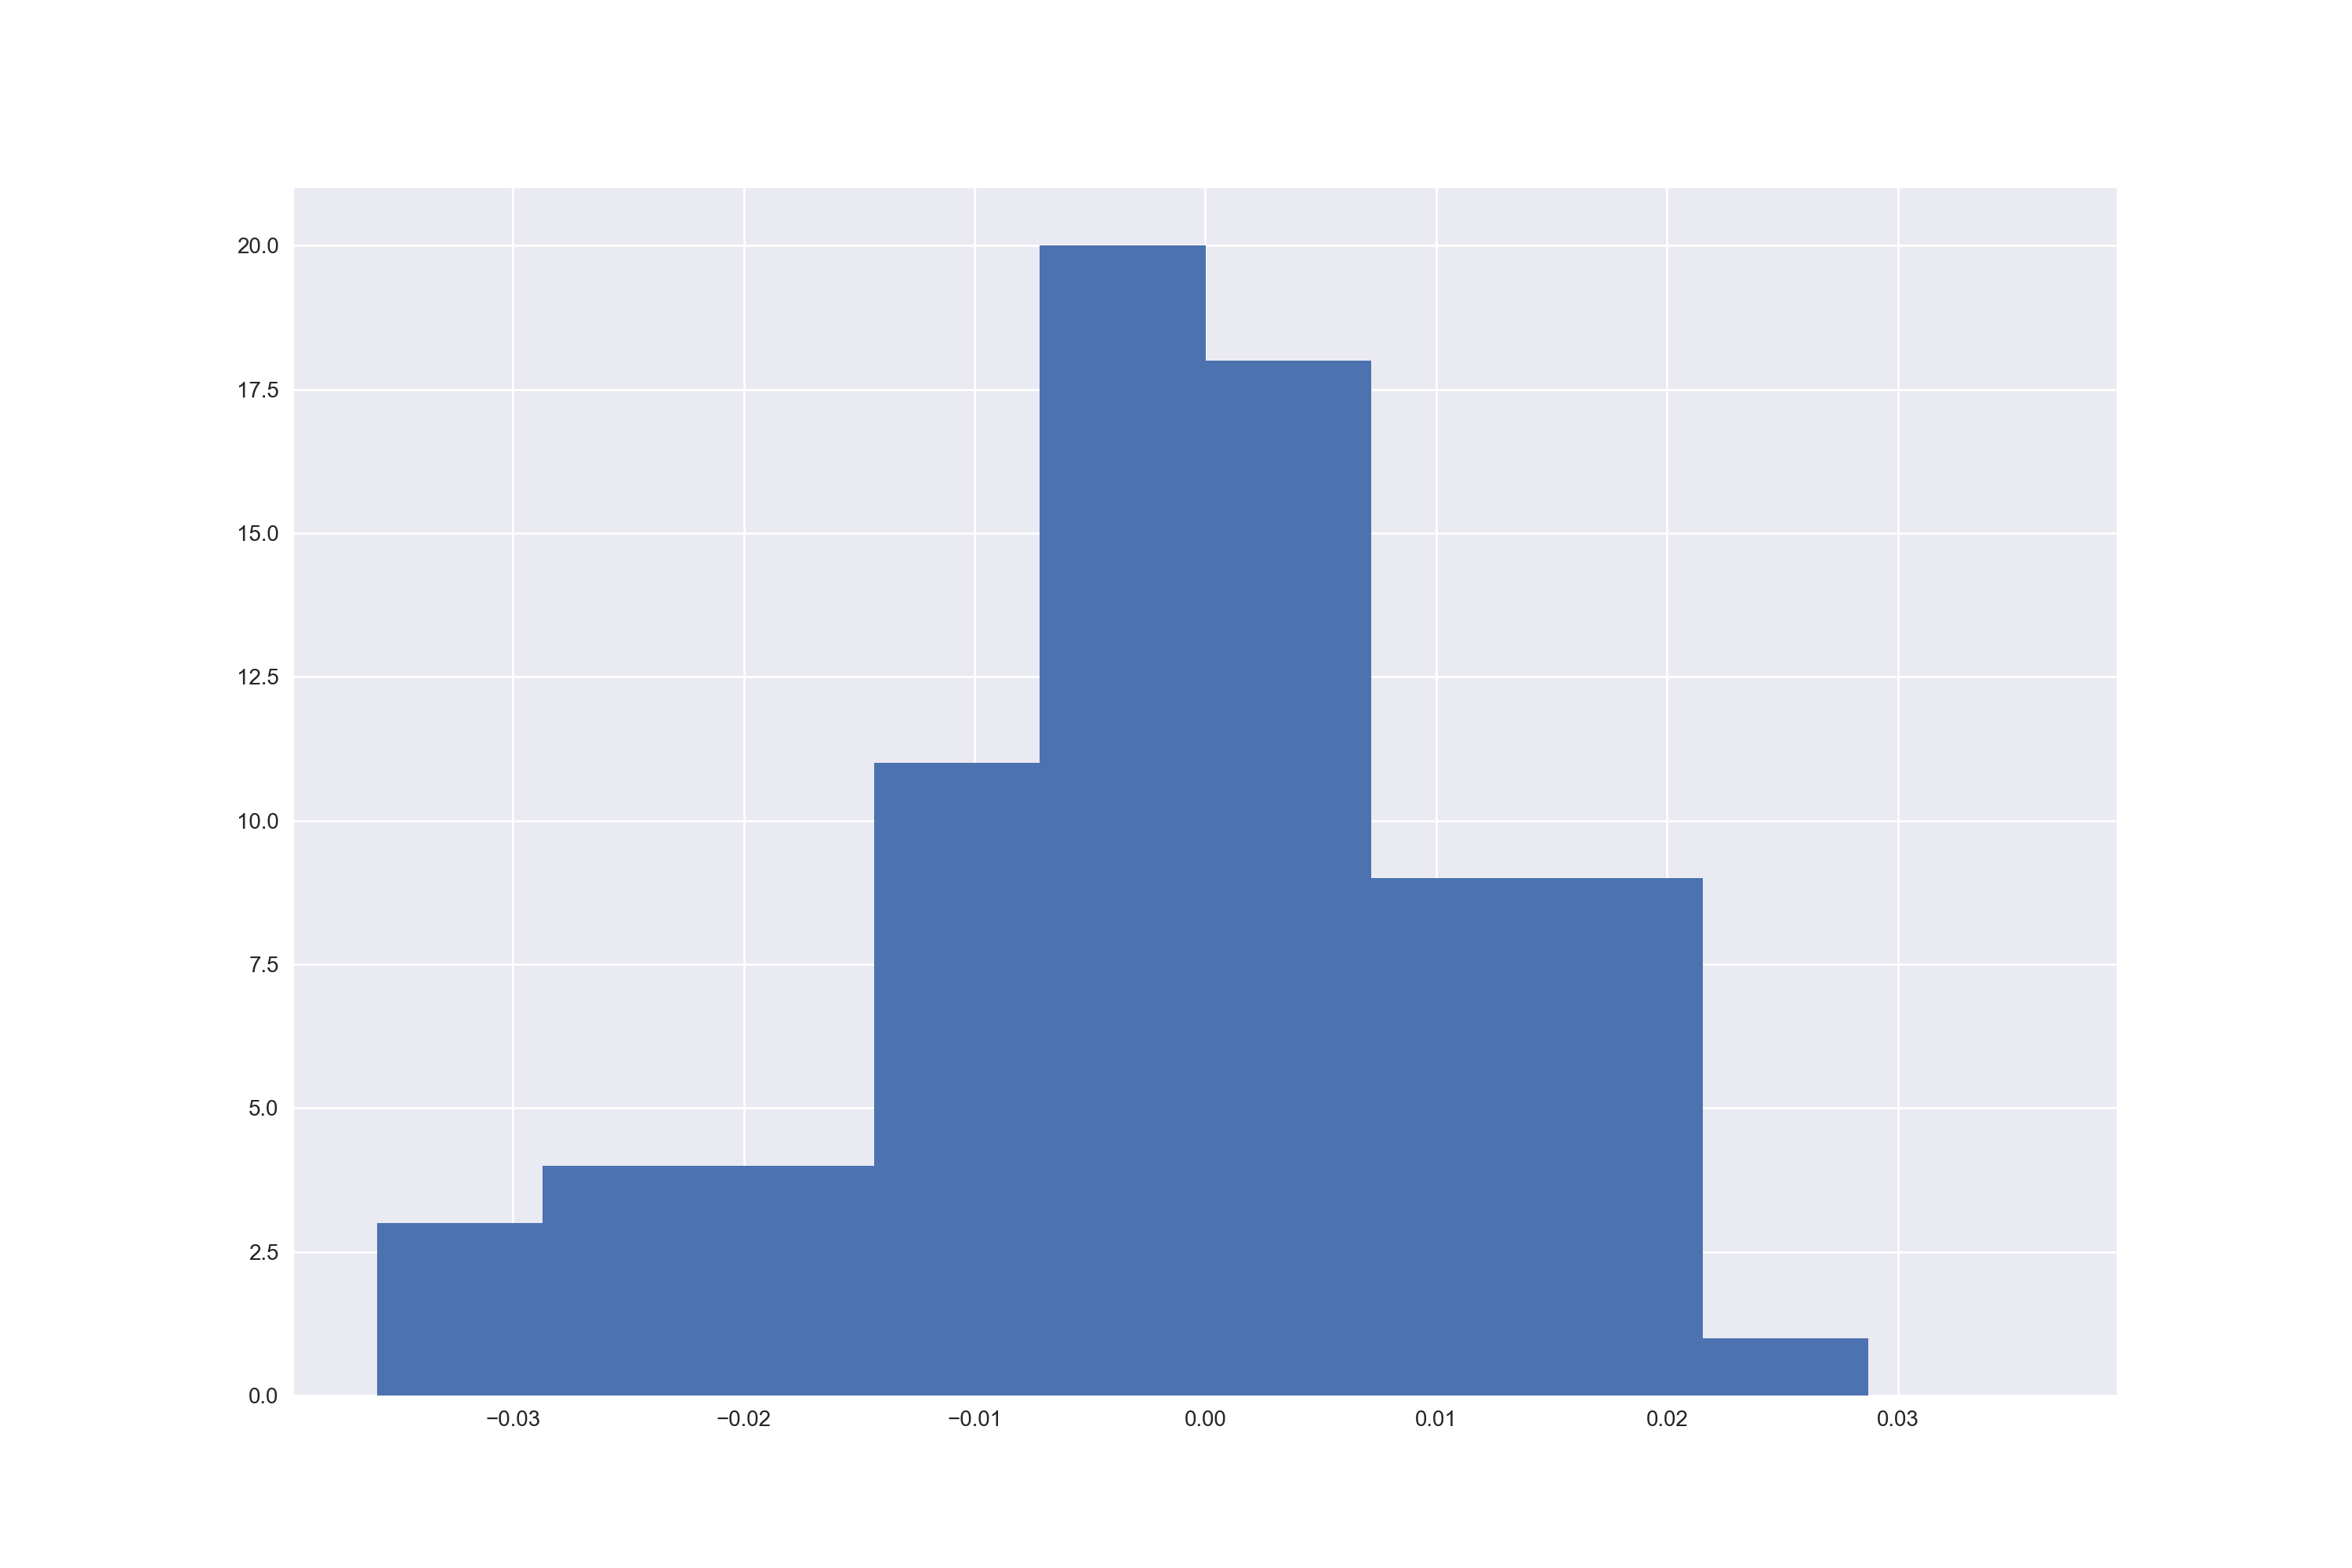

<IPython.core.display.Javascript object>


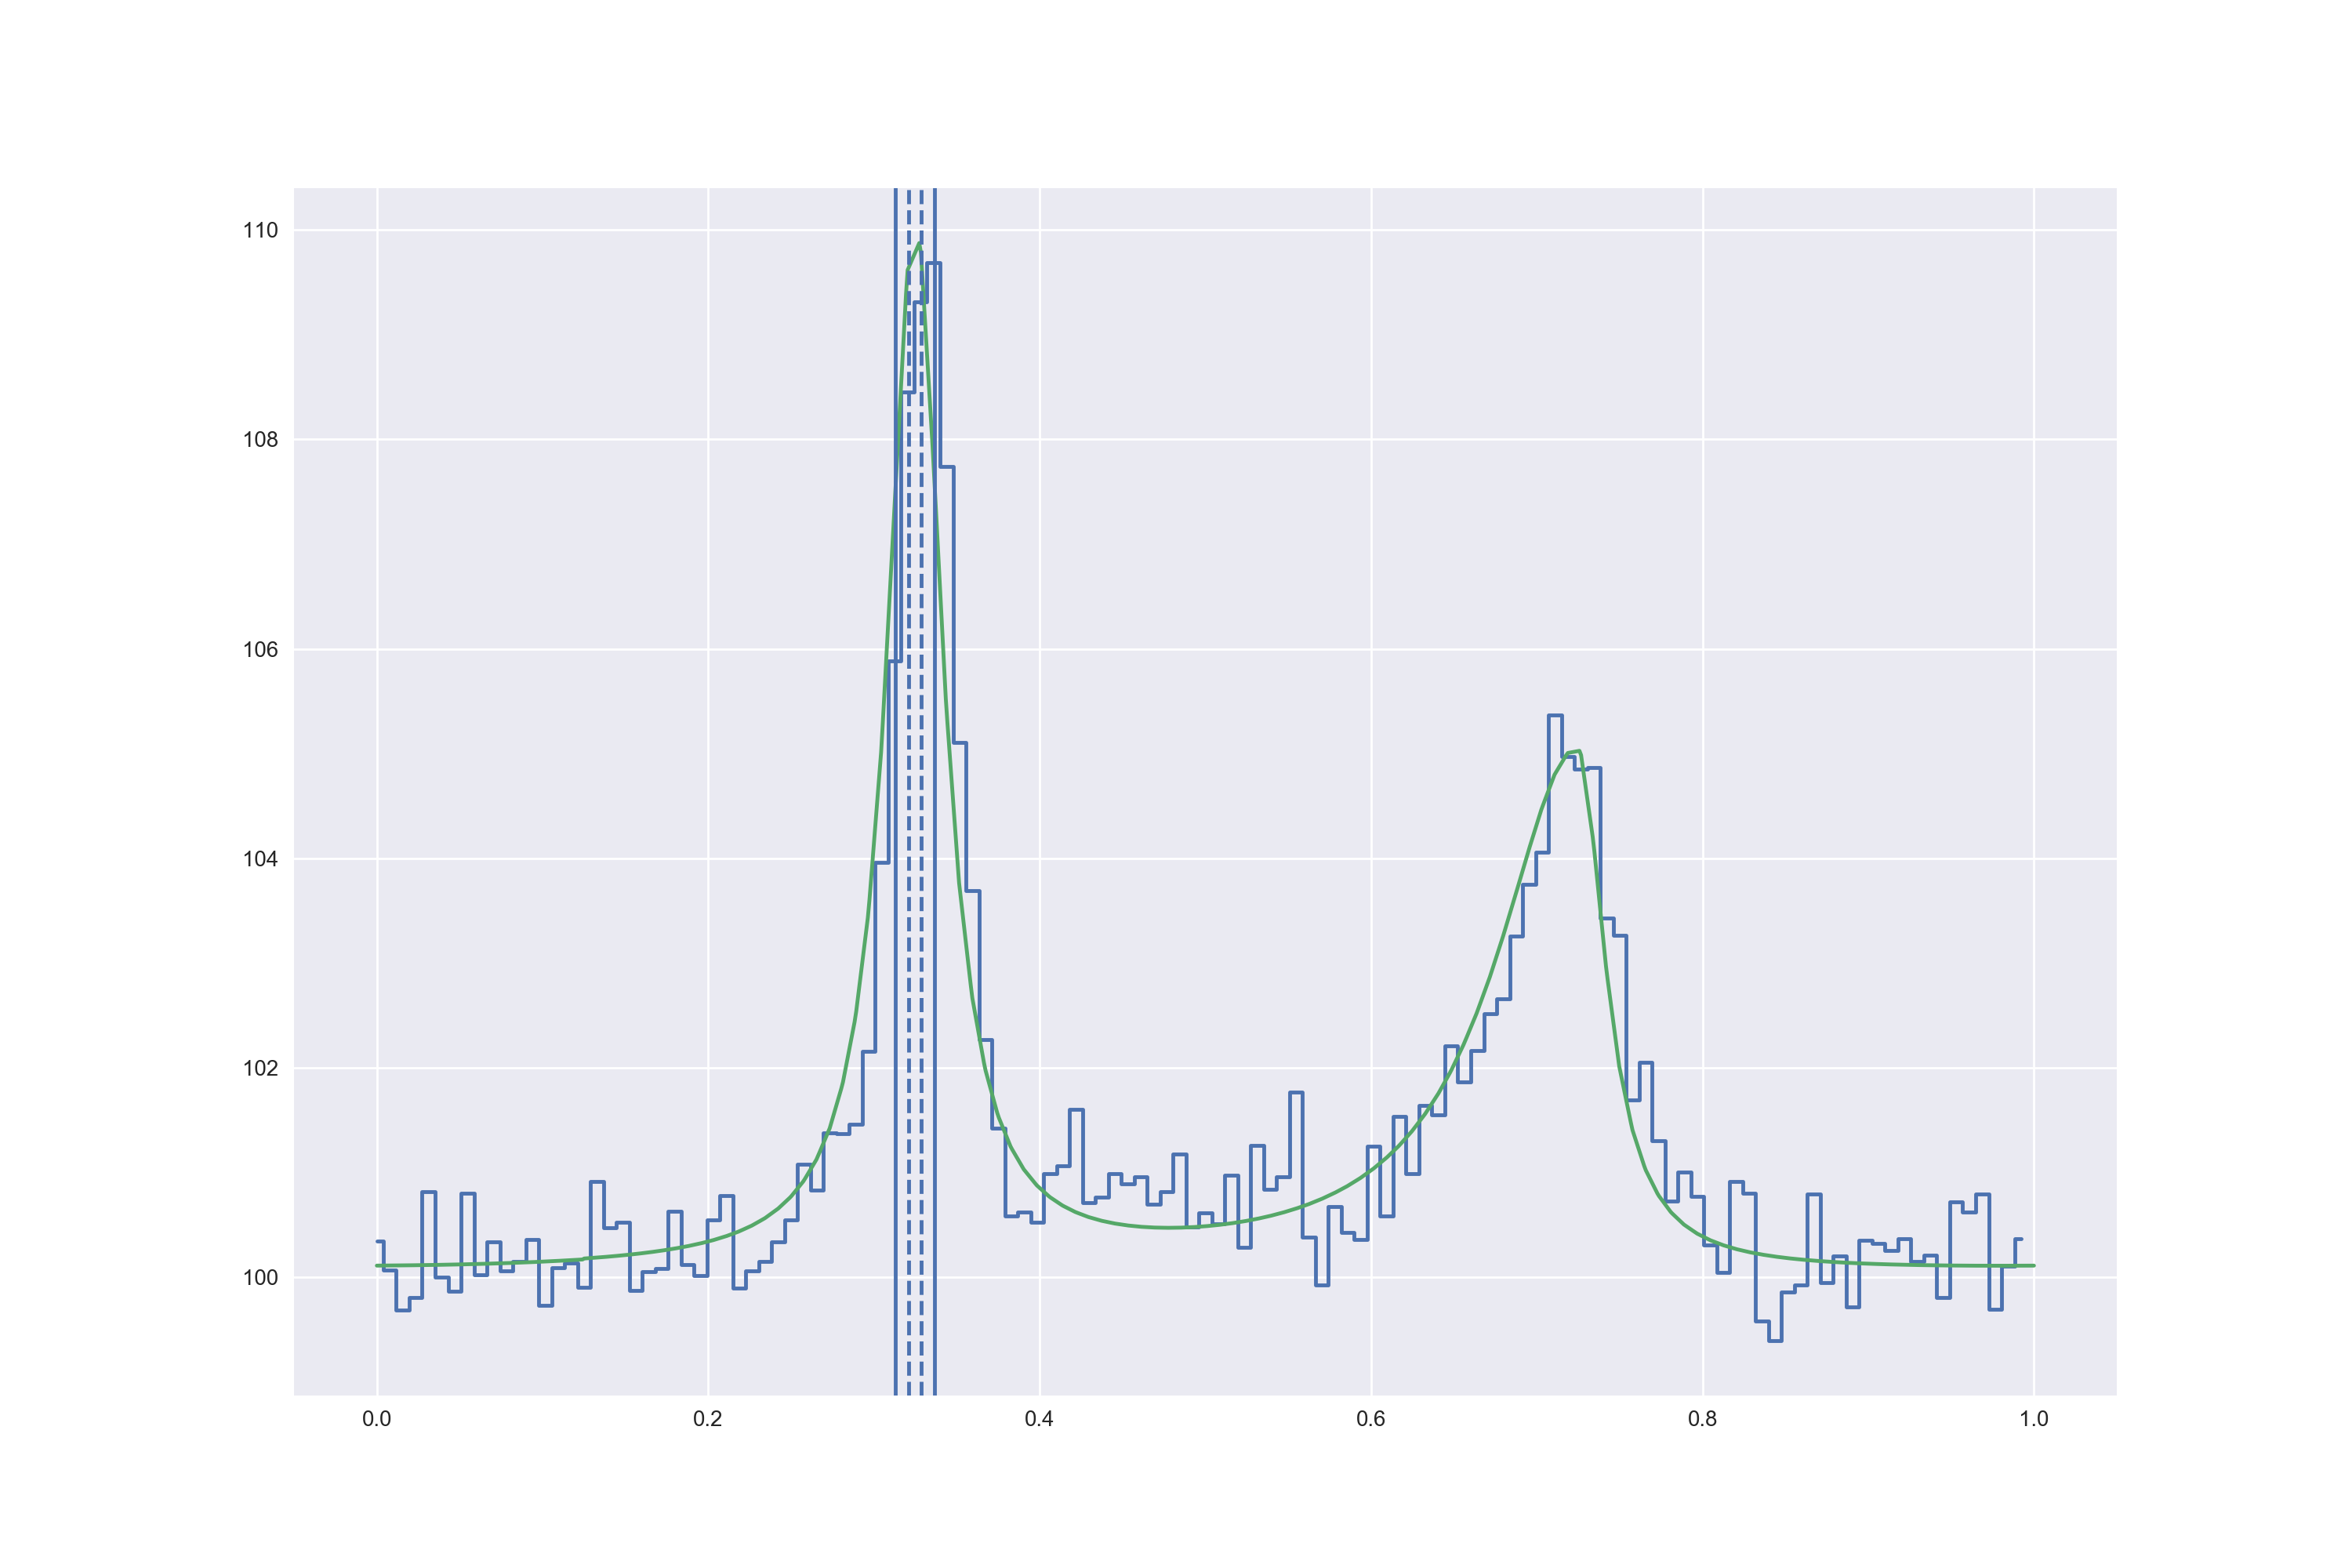

In [7]:
shift = 0.131323
template_rolled = mod(phases - shift)
profile_rolled = np.random.normal(template_rolled, 0.4)

# plt.figure()
# plt.plot(profile_rolled)
period = 2.
toa, toaerr = get_TOA(profile_rolled, period, tstart=0, template=template, 
                      additional_phase=0.2, quick=True, debug=True, use_bootstrap=True)

Not bad, but you'll see that results are not too stable. Now we try to simulate random phases for the pulse, fit it and calculate some statistics on the results.

In [16]:
from tqdm import tqdm
ntrials = 300
shifts = []
errors = []
errors_over_uncert = []
period = 2.

for i in tqdm(range(ntrials)):
    shift = np.random.uniform(0, 1.)
    template_rolled = mod(phases - shift)
    profile_rolled = np.random.normal(template_rolled, 2.)
    toa, toaerr = get_TOA(profile_rolled, period, tstart=0, 
                          quick=True, template=template, additional_phase=0.2)
    error = toa / period - shift - 0.2
    shifts.append(shift)
    error -= np.floor(error)
    if error > 0.5:
        error -= 1.

    errors.append(error)
    errors_over_uncert.append(error / toaerr)
    
errors = np.array(errors)
errors_over_uncert = np.array(errors_over_uncert)

100%|██████████| 300/300 [00:41<00:00,  7.29it/s]


<IPython.core.display.Javascript object>


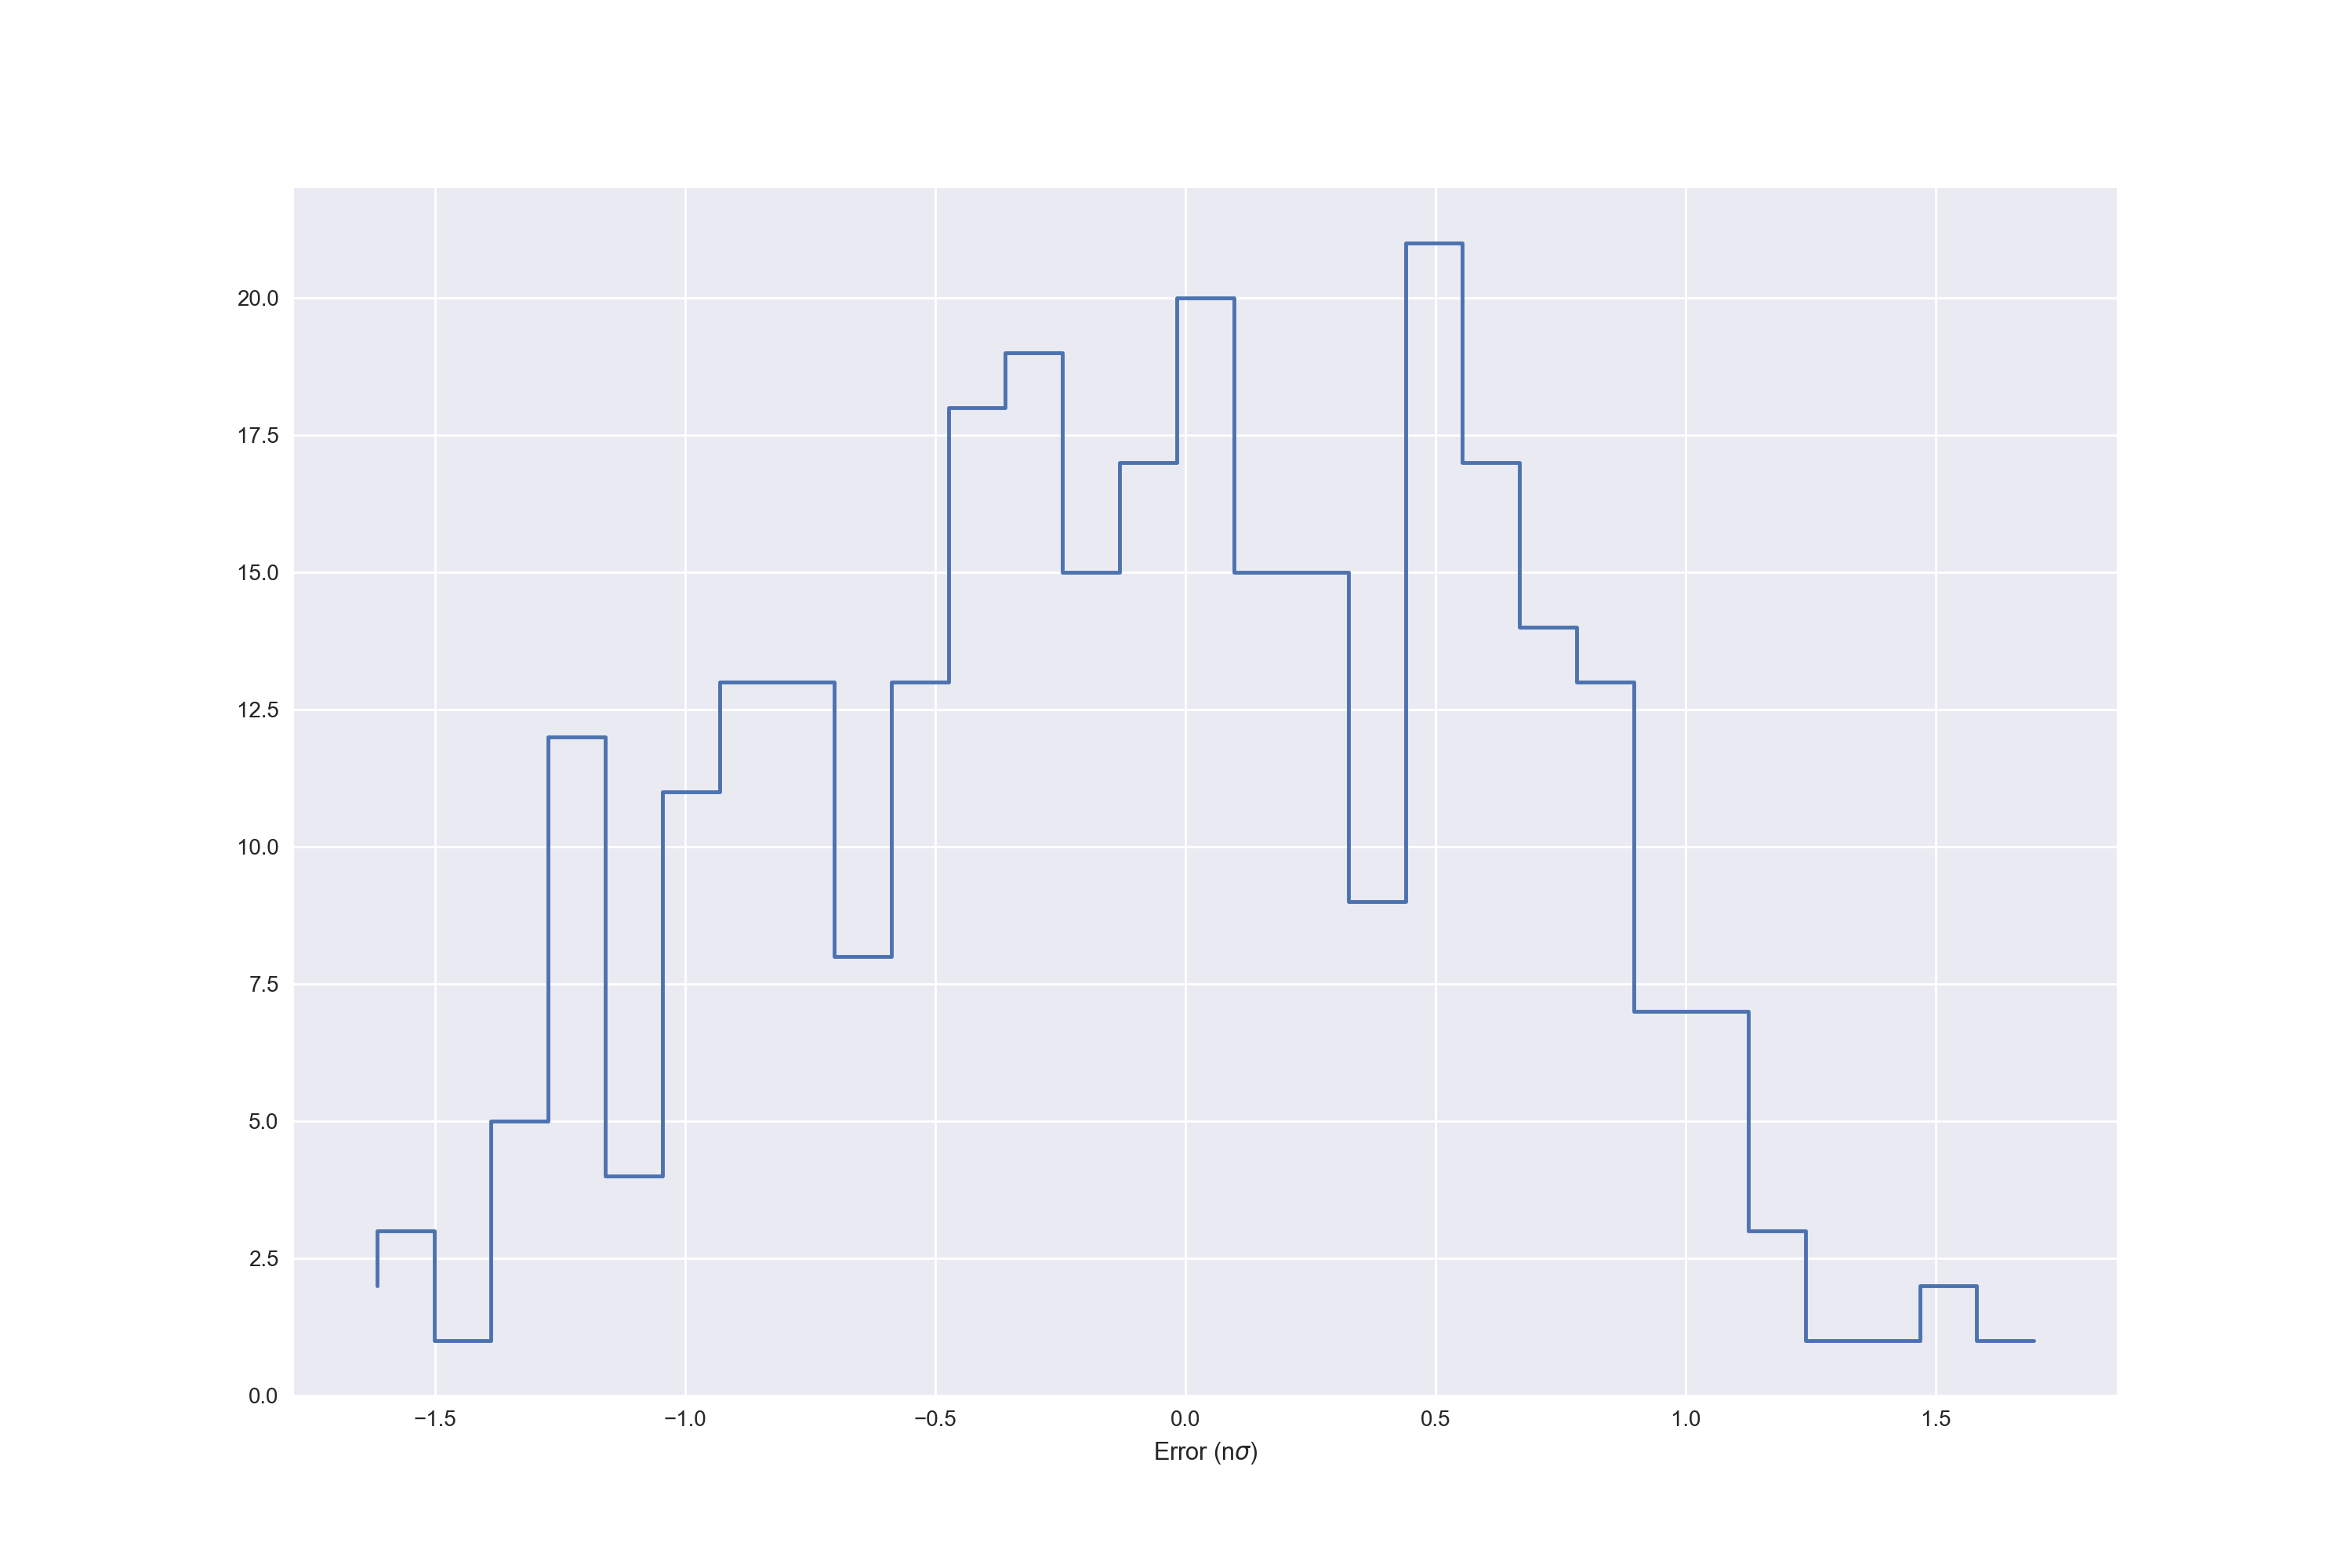

In [17]:
good = np.isfinite(errors_over_uncert)

plt.figure()
hist, bins = np.histogram(errors_over_uncert[good], bins=30)
plt.step(bins[:-1] + np.diff(bins) / 2,  hist)
plt.xlabel(r'Error (n$\sigma$)')

Note that the distribution is quite flat, does not even look Gaussian, but still, it generally gets the pulse profile right inside the +- 1 bin estimated error.

## With quick=False

Without the `quick` option, we use the slower algorithm and we expect results to be generally better. Let's see how much

<IPython.core.display.Javascript object>


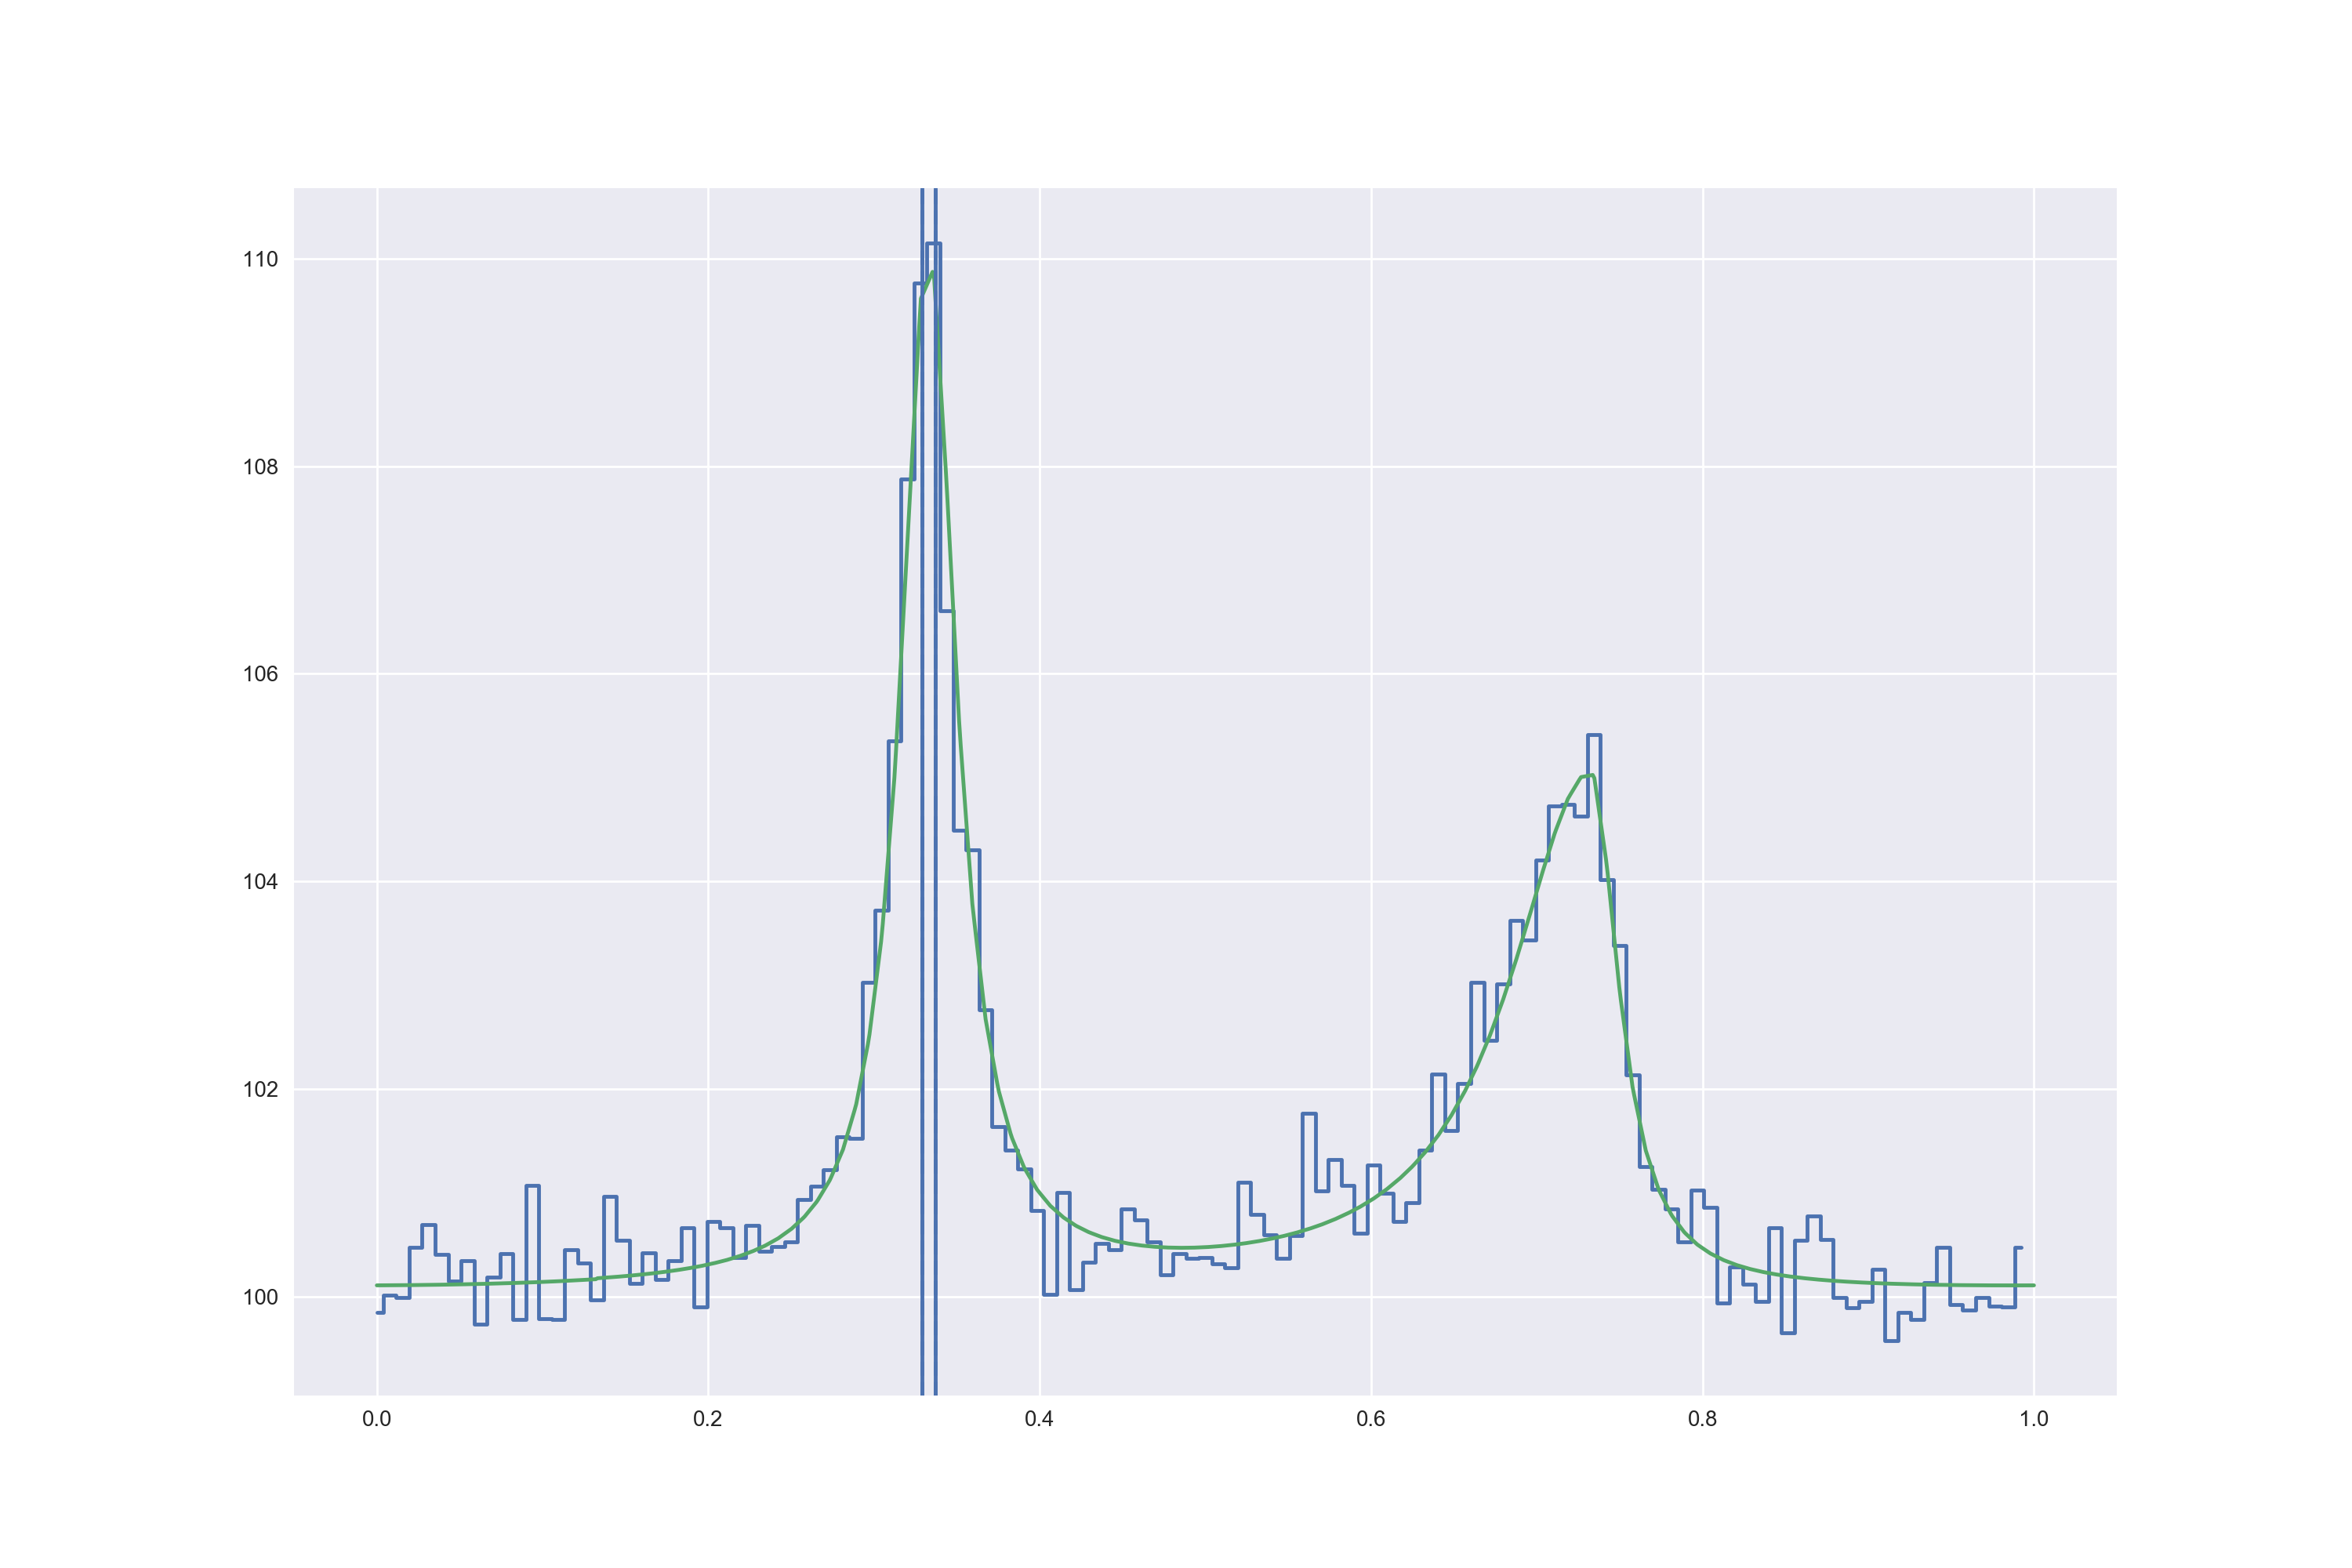

In [10]:
shift = 0.131323
template_rolled = mod(phases - shift)
profile_rolled = np.random.normal(template_rolled, 0.4)

period = 2.
toa, toaerr = get_TOA(profile_rolled, period, tstart=0, template=template, 
                      additional_phase=0.2, debug=True)

And again, we can simulate many realizations and see how it behaves

In [11]:
from tqdm import tqdm
ntrials = 300
shifts = []
errors = []
errors_over_uncert = []
period = 2.

for i in tqdm(range(ntrials)):
    shift = np.random.uniform(0, 1.)
    template_rolled = mod(phases - shift)
    profile_rolled = np.random.normal(template_rolled, 2.)
    toa, toaerr = get_TOA(profile_rolled, period, tstart=0,
                          quick=False, template=template, additional_phase=0.2)
    error = toa / period - shift - 0.2
    shifts.append(shift)
    error -= np.floor(error)
    if error > 0.5:
        error -= 1.

    errors.append(error)
    errors_over_uncert.append(error / toaerr)
    
errors = np.array(errors)
errors_over_uncert = np.array(errors_over_uncert)

100%|██████████| 300/300 [11:53<00:00,  2.38s/it]


<IPython.core.display.Javascript object>


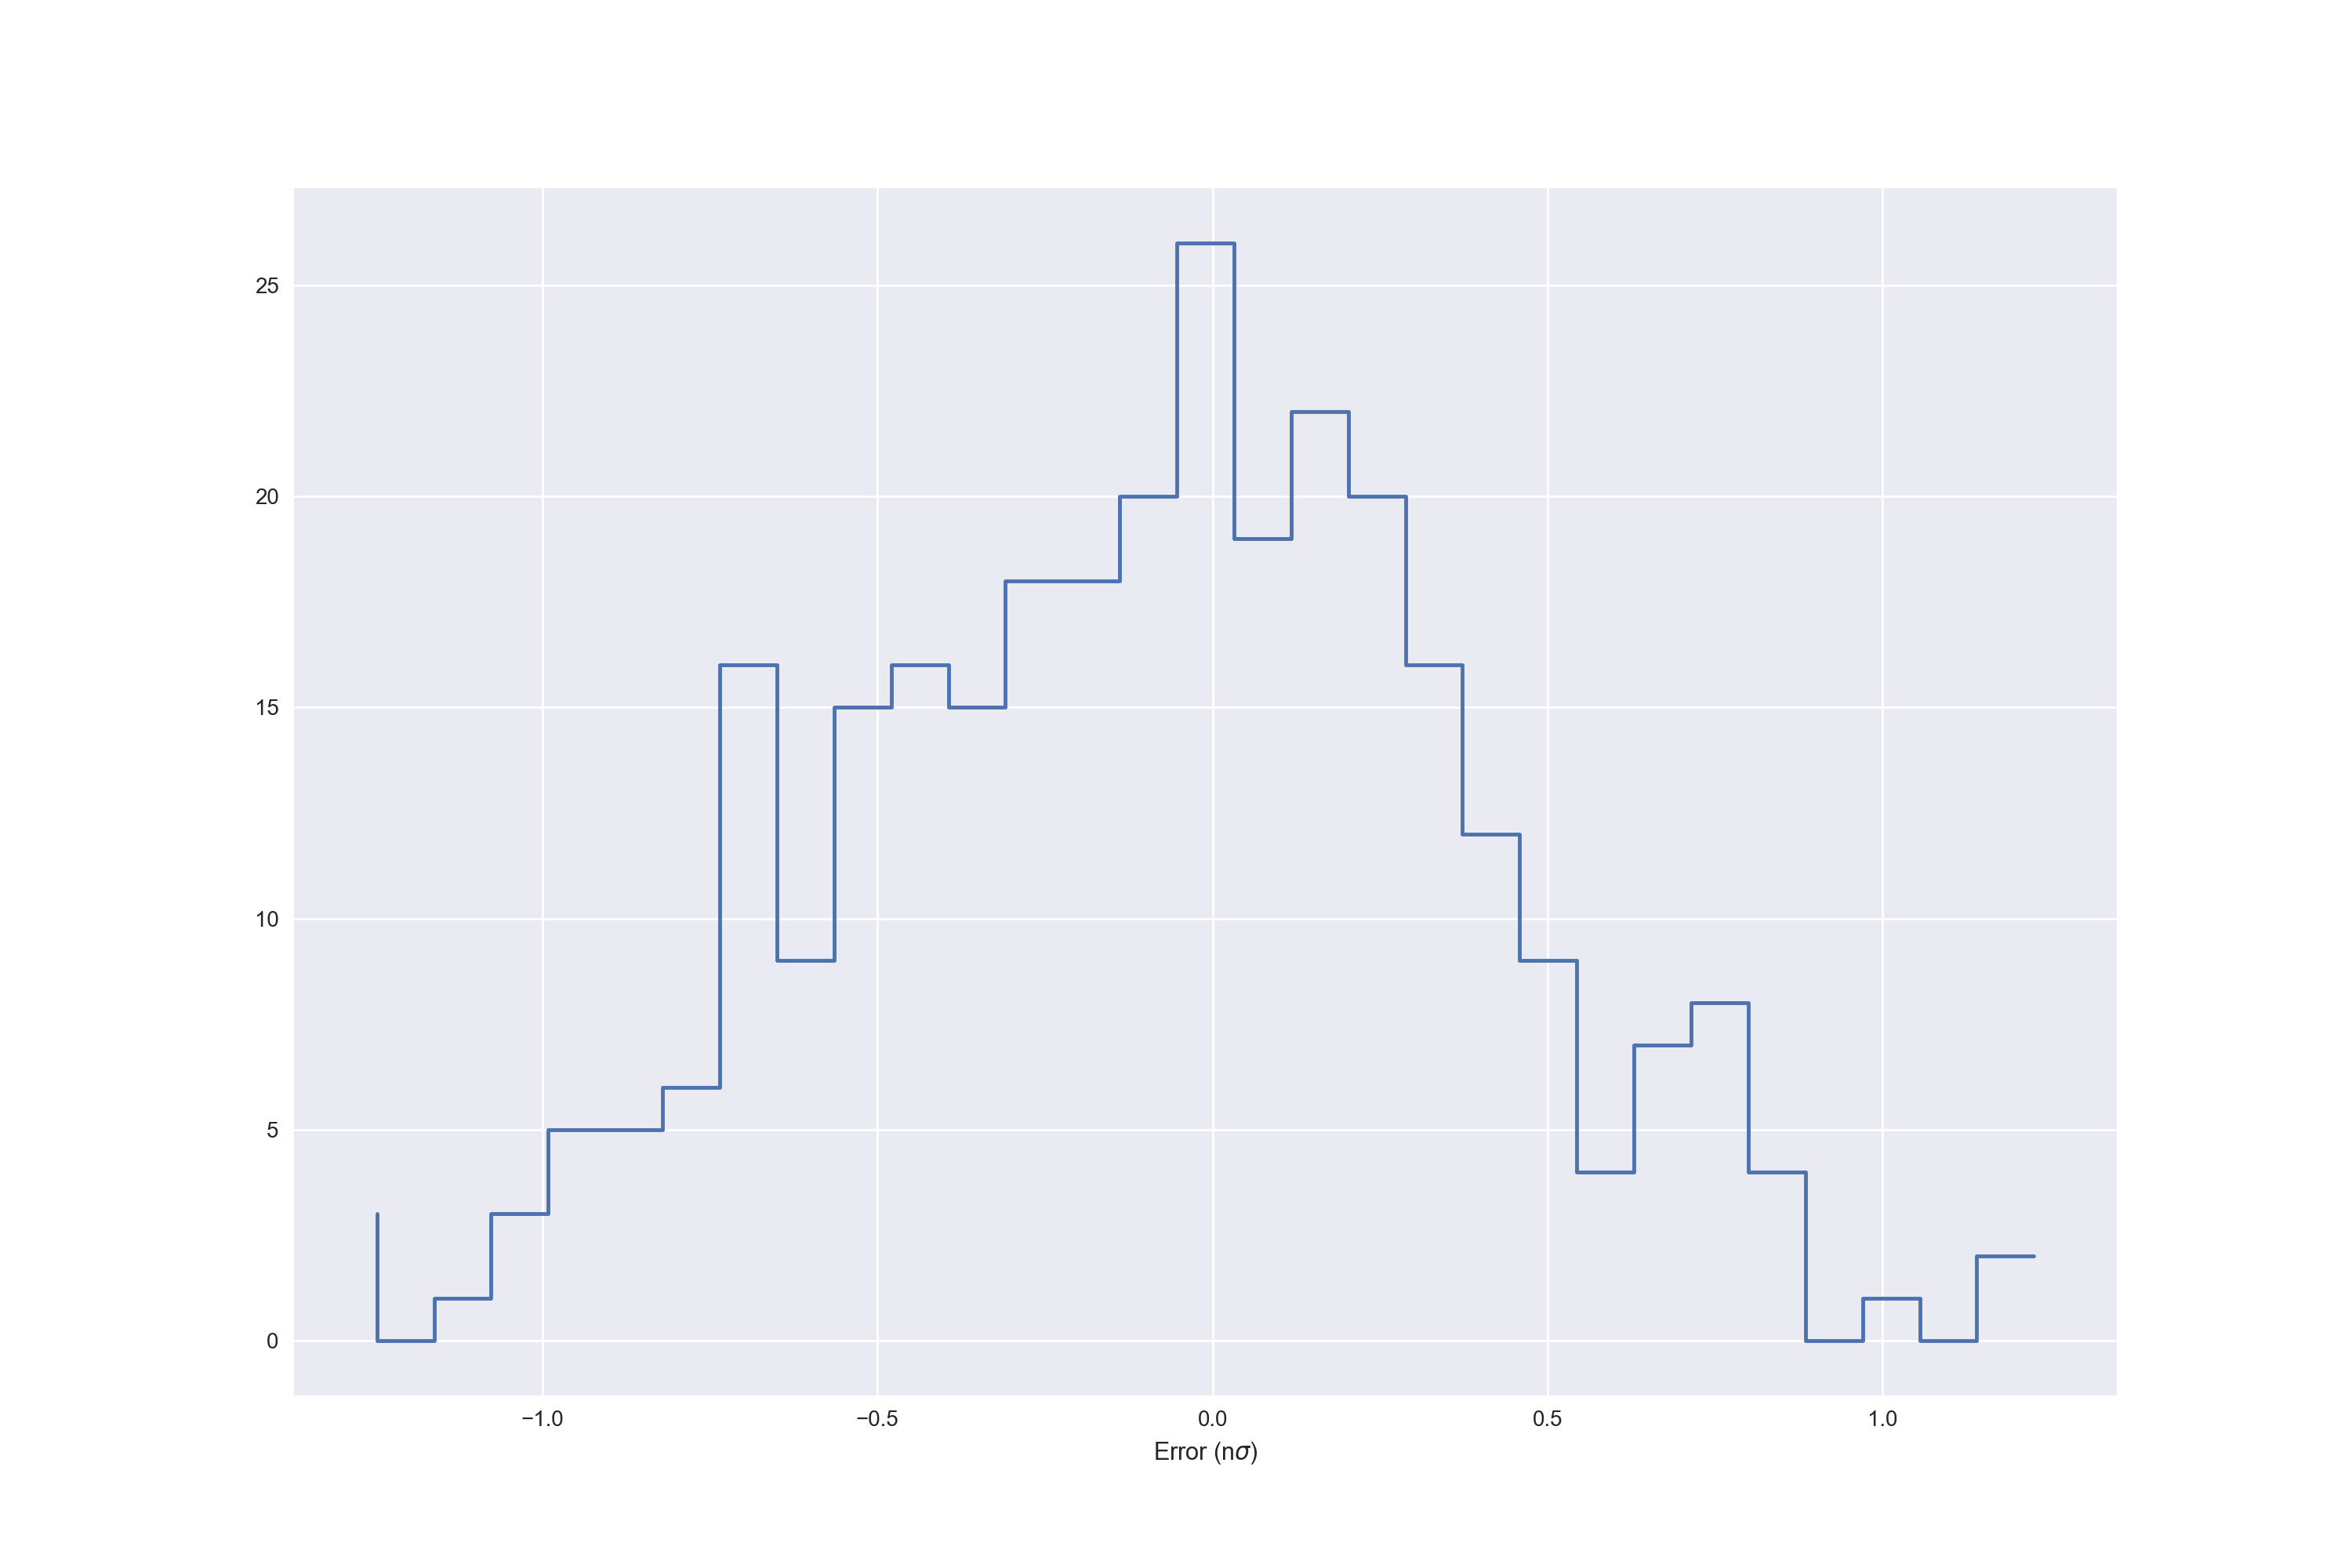

In [14]:
good = np.isfinite(errors_over_uncert)

plt.figure()
hist, bins = np.histogram(errors_over_uncert[good], bins=30)
plt.step(bins[:-1] + np.diff(bins) / 2,  hist)
plt.xlabel(r'Error (n$\sigma$)')

Now the distribution looks more Gaussian, and it does have a narrower spread around the correct value. Therefore, we recommend using `quick=False` when the number of TOAs to calculate is relatively small.